# Financial Risk Management

### By Carlos Santillán

#### Start date: September 20, 2019
#### 2nd Date: April 15, 2020

This notebook is written with the purpose of becoming a repository of useful algorithms used in Financial Risk Management. The language chosen for this notebook is Python, everything will be developed using this language.

The ultimate purpose of this notebook is to become an Interactive Dashboard for Financial Risk Management.

## Table of Contents

To be written

## Import Block

In [49]:
import numpy as np                  # Vectores 
import pandas as pd                 # DataFrames 
import matplotlib.pyplot as plt     # Gráficas 
import math                         # Operaciones 
import seaborn as sns               # Gráficos y controles de Scrapping 
import random                       # Muestreos aleatorios 
import quandl                       # Datasets financieros 
import yahoo_finance                # Acceso a Yahoo Finanzas 
from scipy import stats             # Paquetería estadística 
from scipy.stats import kstest      # Prueba de Kolmogorov-Smirnov 
from scipy.stats import beta        # Distribución Beta 
from scipy.stats import expon       # Distribución Exponencial 
from scipy.stats import uniform     # Distribución uniforme 
from scipy.stats import norm        # Distribución normal 
from scipy.stats import binom       # Distribución Binomial 

### This part is a substitute of istalling directly from promt
import pip 
from pip._internal import main 
main(['install', 'pandas_datareader']) 
#main(['install', 'fix_yahoo_finance']) 
from pandas_datareader import data as web 
#import fix_yahoo_finance 

%matplotlib inline 

## 1. VaR

For this 1st part, I´m going to calculate the **parametric VaR** as well as the **Empirical VaR** of a dataset obtained from Yahoo.
 

In this case, let us use **Swiss Re (SREN.SW)** stock price. 

We will also ask for the user to input the dates he wants to get data from:

In [50]:
def get_quote_data():
    '''
    User will be prompted for quote, start and end date for the price series.
    quote should be introduced as string
    Dates should have format yyyy-mm-dd
    Dates will be entered as string and then transformed into datetime type
    Column 'Adj Close' will be renamed to 'adj_close'
    Output: dataframe with quote's financial data in the selected date range
    '''
    quote = input("Please enter the quote of the company of your interest: ")
    start_Date = input("Please enter start date for price series (format should be yyyy-mm-dd): ")
    end_Date = input("Please enter end date for price series (format should be yyyy-mm-dd): ")
    
    start_Date_Datetime = pd.to_datetime(start_Date)     
    end_Date_Datetime = pd.to_datetime(end_Date)

    dataFrame = web.get_data_yahoo(quote, start_Date_Datetime, end_Date_Datetime)
    
    dataFrame.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
    
    print("You selected " + quote + " as the company you want to download data from")
    print("You selected " + start_Date + " as starting date")
    print("You selected " + end_Date + " as ending date")
    print("Here are the first 5 records of your data:")
    print(dataFrame.head())
    
    return dataFrame


In [51]:
df = get_quote_data()

Please enter the quote of the company of your interest: SREN.SW
Please enter start date for price series (format should be yyyy-mm-dd): 2019-04-15
Please enter end date for price series (format should be yyyy-mm-dd): 2020-04-15
You selected SREN.SW as the company you want to download data from
You selected 2019-04-15 as starting date
You selected 2020-04-15 as ending date
Here are the first 5 records of your data:
                  High         Low        Open       Close     Volume  \
Date                                                                    
2019-04-15  100.849998   99.559998   99.559998  100.849998  1556284.0   
2019-04-16  102.099998  100.500000  100.500000  102.099998  2045818.0   
2019-04-17  102.849998  101.699997  101.800003  102.699997  1348122.0   
2019-04-18  102.949997  101.800003  102.750000  102.849998  2585755.0   
2019-04-23   98.459999   97.440002   98.040001   98.040001  3553079.0   

            adj_close  
Date                   
2019-04-15  95.358894 

Now that we have our data, it would be useful to visualize 'Close' and 'Adj Close':

In [65]:
def plot_close(dataFrame):
    '''
    For any given dataframe, plot columns Close and adj_close
    Output: Plot of Close vs Adj Close
    '''
    plt.plot(dataFrame.index, df['Close'], '-r', label = 'Close')
    plt.plot(dataFrame.index, df['adj_close'], '-b', label = 'Adj Close')
    plt.legend(loc='upper left')
    plt.title("Adjusted Close vs. Close")

    return 


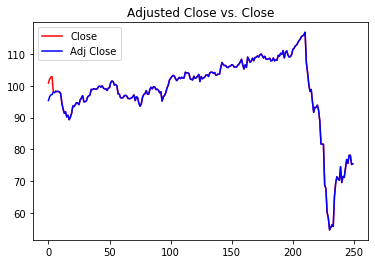

In [66]:
plot_close(df)

For our calculations, we will be using the **Adj Close** column. Using the Ajusted value at Close is convenient for the following reasons:

- Corporate matters (SPLIT)

- Dividends

- Decrease stock price in order to issu more stocks

- Decrease volume of stocks, hence increasing stock price

- It is calculated as the average of the last 3 hours

Now it's time to calculate our returns. This can be done in 2 different ways:

1. Simple returns
2. Logarithmic returns

What's the difference between them?

For instance, the formula for **Simple returns is as follows**

$$R_{t+1} = \frac{Price_{t+1}}{Price_{t}} -1 $$

and the formula for **Logarithmic returns** is as follows:

$$R_{t+1}ln = ln(\frac{Price_{t+1}}{Price_{t}}) $$


So, as you can see, Simple Returns is actually just looking at the difference in percentage between the two values, current and past price, whereas Logarithmic Returns gets the natural logarithm of the quotient of both.

For convenience we will calculate both, but for the rest of our calculations we will use Logarithmic Returns.

Why? Because returns calculated that way allow us to use properly the **Black-Scholes Formula**

Notice that in this format of dataframe, our 'Adj Close' column is always in the 6th position, hence we can make a reference to it using *.iloc[]* with the index 5 (since Python begins enumerating from 0)

In [52]:
def calculate_returns(dataFrame):
    '''
    Input: dataframe with financial data
    Column with Adj Close must be in the 6th position if it is to be referenced with .iloc
    Calculate simple returns of Adj Close
    Calculate logarithmic returns of Adj Close
    Output: dataframe with 2 additional columns
    '''
    
    ### Get adj_close as a Numpy array
    adj_Close_np = np.asarray(dataFrame['adj_close'])
    
    ### Construct return arrays, with dimension of adf_close -1
    simple_Returns = np.zeros(len(adj_Close_np) - 1)
    log_Returns = np.zeros(len(adj_Close_np) - 1)
    
    ### Calculate simple and log returns
    for i in range(len(adj_Close_np) - 1):
        simple_Returns[i] = (adj_Close_np[i+1] / adj_Close_np[i]) - 1
        log_Returns[i] = np.log(adj_Close_np[i+1] / adj_Close_np[i])
    
    ### Convert returns to Pandas Series
    simple_Returns_pd = pd.Series(simple_Returns)
    log_Returns_pd = pd.Series(log_Returns)
    
    ### For our columns to be included, we need both dataframes to have the same index
    ### so we will turn 'Date' into a column and then we´ll return it as index
    dataFrame.reset_index(inplace=True,drop=False)
    
    ### Duplicate Date column in order to have one as well as the index
    dataFrame['date_col'] = dataFrame['Date']
    
    ### Include return´s series in dataframe
    dataFrame['simple_returns'] = simple_Returns_pd
    dataFrame['log_returns'] = log_Returns_pd
    
    ### Shift returns columns 1 space below
    dataFrame['simple_returns'] = dataFrame['simple_returns'].shift(+1)
    dataFrame['log_returns'] = dataFrame['log_returns'].shift(+1)
    
    ### Return Date column to index
    dataFrame = dataFrame.set_index('Date')
    
    return dataFrame

In [53]:
df2 = calculate_returns(df)
df2.head()

,High,Low,Open,Close,Volume,adj_close,date_col,simple_returns,log_returns
Date,,,,,,,,,
2019-04-15,100.849998,99.559998,99.559998,100.849998,1556284.0,95.358894,2019-04-15,NaN,NaN
2019-04-16,102.099998,100.500000,100.500000,102.099998,2045818.0,96.540833,2019-04-16,0.012395,0.012318
2019-04-17,102.849998,101.699997,101.800003,102.699997,1348122.0,97.108162,2019-04-17,0.005877,0.005859
2019-04-18,102.949997,101.800003,102.750000,102.849998,2585755.0,97.250000,2019-04-18,0.001461,0.001460
2019-04-23,98.459999,97.440002,98.040001,98.040001,3553079.0,98.040001,2019-04-23,0.008123,0.008091


Now it would be useful to visualize the distribution of our returns:

In [76]:
def plot_returns_distribution(dataFrame):
    '''
    For a given Dataframe, plot the distribution of the log_returns
    Output: Plot of frequencies 
    '''
    returns = np.asarray(dataFrame['log_returns'])          ### turn column into numpy array
    returns = returns[np.logical_not(np.isnan(returns))]    ### remove NaN values from array
    
    sns.distplot(returns)
    plt.title("Distribution of Log Returns")
    
    return 

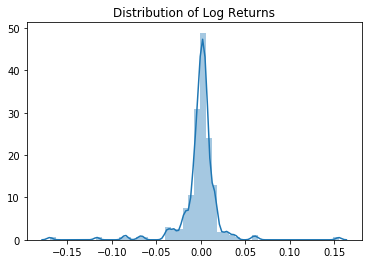

In [77]:
plot_returns_distribution(df2)

We can now proceed to calculate **Parametric VaR**.

For this, it will be necessary to calculate the mean $\mu$ and the standard deviation $\sigma$ of our log returns, as well as to prompt user for the value of the position taken:


In [86]:
def get_parametric_VaR(dataFrame):
    '''
    For a given dataframe, we will calculate the Parametric VaR
    Calculates mean of log returns
    Calculates standard deviation of log returns
    Prompts user for position value
    Calculates negative and positive VaR
    Quantiles considered will be 95%, 99.5% and 99.9%
    Output: table with mean, stdev, value position and VaR in negative and positive values
    '''
    
    ### Prompt user for position value
    position_Value = input("Enter value of position taken (no commas)")
    print("Position value is: " + position_Value)
    
    ### Covnert position value to float
    position_Value = float(position_Value)
    
    ### Calculate mean and stdev of log-returns
    mean_Returns = dataFrame['log_returns'].mean()
    stdev_Returns = dataFrame['log_returns'].std()
    
    ### Calculate inverse of normal distribution (quantile function)
    z_95 = norm.ppf(0.95)
    z_995 = norm.ppf(0.995)
    z_999 = norm.ppf(0.999)
    
    ### Calculate Negative VaR
    neg_VaR_95 = mean_Returns - (z_95 * stdev_Returns)
    neg_VaR_995 = mean_Returns - (z_995 * stdev_Returns)
    neg_VaR_999 = mean_Returns - (z_999 * stdev_Returns)
    
    ### Calculate Positive VaR
    pos_VaR_95 = mean_Returns + (z_95 * stdev_Returns)
    pos_VaR_995 = mean_Returns + (z_995 * stdev_Returns)
    pos_VaR_999 = mean_Returns + (z_999 * stdev_Returns)
    
    ### Calculate VaR in terms of Position Value
    neg_Value_VaR_95 = neg_VaR_95 * position_Value
    neg_Value_VaR_995 = neg_VaR_995 * position_Value
    neg_Value_VaR_999 = neg_VaR_999 * position_Value
    pos_Value_VaR_95 = pos_VaR_95 * position_Value
    pos_Value_VaR_995 = pos_VaR_995 * position_Value
    pos_Value_VaR_999 = pos_VaR_999 * position_Value
    
    ### Convert VaR into percentage
    neg_VaR_95 = neg_VaR_95 * 100
    neg_VaR_995 = neg_VaR_995 * 100
    neg_VaR_999 = neg_VaR_999 * 100
    pos_VaR_95 = pos_VaR_95 * 100
    pos_VaR_995 = pos_VaR_995 * 100
    pos_VaR_999 = pos_VaR_999 * 100
    
    ### Print mean and stdev
    print("The mean of our returns is: " + str(mean_Returns))
    print("The stdev of our returns is: " + str(stdev_Returns))
    
    ### Display VaR in 2 different dataframes, one for negative and the other for positive
    column_Names = ['95%', '99.5%', '99.9%']                     ### declare names for the columns 
    neg_index_Names = ['Zq', '-VaR(1-q)', '-VaR in Value']       ### row names for negative VaR
    pos_index_Names = ['Zq', '+VaR(1-q)', '+VaR in Value']       ### row names for positive VaR
    
    dfObj_Negative = pd.DataFrame(columns = column_Names, index = neg_index_Names)     ### empty dataframe
    dfObj_Positive = pd.DataFrame(columns = column_Names, index = pos_index_Names)     ### empty dataframe
    
    zq_list = [z_95, z_995, z_999]
    neg_VaR_list = [neg_VaR_95, neg_VaR_995, neg_VaR_999]
    neg_Value_list = [neg_Value_VaR_95, neg_Value_VaR_995, neg_Value_VaR_999]
    pos_VaR_list = [pos_VaR_95, pos_VaR_995, pos_VaR_999]
    pos_Value_list = [pos_Value_VaR_95, pos_Value_VaR_995, pos_Value_VaR_999]
    
    ### Append rows to empty dataframes
    dfObj_Negative.loc['Zq'] = zq_list
    dfObj_Negative.loc['-VaR(1-q)'] = neg_VaR_list
    dfObj_Negative.loc['-VaR in Value'] = neg_Value_list
    dfObj_Positive.loc['Zq'] = zq_list
    dfObj_Positive.loc['+VaR(1-q)'] = pos_VaR_list
    dfObj_Positive.loc['+VaR in Value'] = pos_Value_list
    
    print(dfObj_Negative)
    print(dfObj_Positive)
    
    return neg_VaR_list, pos_VaR_list
    

In [87]:
get_parametric_VaR(df2)

Enter value of position taken (no commas)1000000
Position value is: 1000000
The mean of our returns is: -0.0009399393829026435
The stdev of our returns is: 0.023033482486143123
                   95%    99.5%    99.9%
Zq             1.64485  2.57583  3.09023
-VaR(1-q)     -3.88266 -6.02703 -7.21188
-VaR in Value -38826.6 -60270.3 -72118.8
                   95%    99.5%    99.9%
Zq             1.64485  2.57583  3.09023
+VaR(1-q)      3.69468  5.83904  7.02389
+VaR in Value  36946.8  58390.4  70238.9


([-3.882664659155837, -6.0270258533490475, -7.211875108513264],
 [3.694676782575309, 5.83903797676852, 7.023887231932736])

For contrasting purposes, it would be nice to also get our **Empirical VaR**:

In [88]:
def get_empirical_VaR(dataFrame):
    '''
    For a given dataframe, calculate Empirical VaR
    Calculate VaR for 95%, 99.5% and 99.9% confidence levels
    User will be prompted for position value
    '''
    ### Prompt user for position value
    position_Value = input("Enter value of position taken (no commas)")
    print("Position value is: " + position_Value)
    
    ### Covnert position value to float
    position_Value = float(position_Value)
    
    ### Get quantile of log returns
    neg_Empirical_VaR_95 = (dataFrame['log_returns'].quantile(1 - 0.95)) * 100
    neg_Empirical_VaR_995 = (dataFrame['log_returns'].quantile(1 - 0.995)) * 100
    neg_Empirical_VaR_999 = (dataFrame['log_returns'].quantile(1 - 0.999)) * 100
    pos_Empirical_VaR_95 = (dataFrame['log_returns'].quantile(0.95)) * 100
    pos_Empirical_VaR_995 = (dataFrame['log_returns'].quantile(0.995)) * 100
    pos_Empirical_VaR_999 = (dataFrame['log_returns'].quantile(0.999)) * 100
    
    ### Create lists of resulting VaR
    neg_Empirical_VaR_list = [neg_Empirical_VaR_95, neg_Empirical_VaR_995, neg_Empirical_VaR_999]
    pos_Empirical_VaR_list = [pos_Empirical_VaR_95, pos_Empirical_VaR_995, pos_Empirical_VaR_999]
    
    ### Generate VaR in terms of value
    neg_Value_95 = (neg_Empirical_VaR_95 * position_Value) / 100
    neg_Value_995 = (neg_Empirical_VaR_995 * position_Value) / 100
    neg_Value_999 = (neg_Empirical_VaR_999 * position_Value) / 100
    pos_Value_95 = (pos_Empirical_VaR_95 * position_Value) / 100
    pos_Value_995 = (pos_Empirical_VaR_995 * position_Value) / 100
    pos_Value_999 = (pos_Empirical_VaR_999 * position_Value) / 100
    
    ### Create list of resulting VaR in values
    neg_Value_list = [neg_Value_95, neg_Value_995, neg_Value_999]
    pos_Value_list = [pos_Value_95, pos_Value_995, pos_Value_999]
    
    ### Display VaR in 2 different dataframes, one for negative and the other for positive
    column_Names = ['95%', '99.5%', '99.9%']               ### declare names for the columns 
    neg_index_Names = ['-VaR(1-q)', '-VaR in Value']       ### row names for negative VaR
    pos_index_Names = ['+VaR(1-q)', '+VaR in Value']       ### row names for positive VaR
    
    dfObj_Negative = pd.DataFrame(columns = column_Names, index = neg_index_Names)     ### empty dataframe
    dfObj_Positive = pd.DataFrame(columns = column_Names, index = pos_index_Names)     ### empty dataframe
    
    ### Fill dataframes
    dfObj_Negative.loc['-VaR(1-q)'] = neg_Empirical_VaR_list
    dfObj_Negative.loc['-VaR in Value'] = neg_Value_list
    dfObj_Positive.loc['+VaR(1-q)'] = pos_Empirical_VaR_list
    dfObj_Positive.loc['+VaR in Value'] = pos_Value_list
    
    print(dfObj_Negative)
    print(dfObj_Positive)
    
    return neg_Empirical_VaR_list, pos_Empirical_VaR_list
    
    

In [89]:
get_empirical_VaR(df2)

Enter value of position taken (no commas)1000000
Position value is: 1000000
                   95%    99.5%    99.9%
-VaR(1-q)     -3.05174 -10.9527 -15.6691
-VaR in Value -30517.4  -109527  -156691
                   95%    99.5%    99.9%
+VaR(1-q)      1.78684  6.16069  13.1879
+VaR in Value  17868.4  61606.9   131879


([-3.051742516140344, -10.952660607525042, -15.669107462141941],
 [1.7868394912520413, 6.160690459071599, 13.187903898960455])

So what have we actually gotten?

Well, let's talk abut how shouldour calculations be interpreted. For instance, letus look at our **Parametric VaR** results, particularly at the value for 95% confidence in the row '-VaR(1-q)'.

We can observe the value $-3.88266$, let us also remember that we´re looking at daily data. So, we should interpret this as:

- With a confidence of 95% (i.e. with a probability of 5%) the worst scenario we can observe in a day (auming no intra-day trading) is that our stock looses $3.88266%$, 

- or in terms of the value of our position (in this case, $1,000,000$ CHF) we can loose up to $38,826$ CHF

# Parte correspondiente al curso, última update el 20/09/2019

## Bloque inicial

In [3]:
import numpy as np                  # Vectores
import pandas as pd                 # DataFrames
import matplotlib.pyplot as plt     # Gráficas
import math                         # Operaciones
from scipy import stats             # Paquetería estadística
from scipy.stats import kstest      # Prueba de Kolmogorov-Smirnov
from scipy.stats import beta        # Distribución Beta
from scipy.stats import expon       # Distribución Exponencial
from scipy.stats import norm        # Distribución Normal

%matplotlib inline   

- Consideraremos valores diarios, así que declaramos vectores de 365

In [22]:
### LLenamos vector con valores tomados de la Normal Inversa (0, 1)
mu = 0.005     ### mu de Black-Scholes
sigma = 0.02   ### sigma de Black-Scholes
n = 365        ### tamaño del vector
S0 = 40        ### Precio inicial

Nt = np.zeros(n)
Wt = np.zeros(n)

for i in range(0, len(Nt)-1):
    Nt[i] = np.random.uniform(0,1)

Wt = norm.ppf(Nt)

2. Construimos vector de valores acumulados (trayectoria) de $W_{t}$


In [15]:
trayWt = np.zeros(n)
trayWt[0] = Wt[0]
for i in range(0, len(trayWt)-1):
    trayWt[i+1] = trayWt[i] + Wt[i+1] 


3. Construimos el vector de $\mu + \sigma W_{t}$

In [19]:
muSigmaWt = np.zeros(n)
for i in range(0, len(muSigmaWt)-1):
    muSigmaWt[i] = mu + sigma*Wt[i]


4. Construimos trayectorias de $\mu + \sigma W_{t}$

In [21]:
trayMuSigmaWt = np.zeros(n)
trayMuSigmaWt[0] = muSigmaWt[0]
for i in range(0, len(trayMuSigmaWt)-1):
    trayMuSigmaWt[i+1] = trayMuSigmaWt[i] + muSigmaWt[i+1]